# Load Data

In [134]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# for interactive plots replace 'inline' with 'widget' and run in standalone jupyter notebook/lab
import os
import os.path
from sepia.SepiaModel import SepiaModel
from sepia.SepiaData import SepiaData as SepiaData
import numpy as np
import sepia.SepiaPlot as SepiaPlot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from nedderimp import nedderimp
from scipy.interpolate import interp2d
from copy import deepcopy
from sepia.SepiaOptim import SepiaOptim as SepiaOptim
import pandas as pd
import pickle
design = pickle.load(open('pkls/nedderDesign.pkl', "rb"))
data = pickle.load(open('pkls/nedderData.pkl', "rb"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Case 1: No optimization, use step size tuning

In [29]:
print(data)

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 572, obs y dimension ragged
n  =     3 (number of observed data)
m  =    36 (number of simulated data)
p  =     1 (number of inputs)
q  =     2 (number of additional simulation inputs to calibrate)
pu =     3 (transformed response dimension)
pv =    24 (transformed discrepancy dimension)
Categorical x input variables:
Categorical t input variables:



In [30]:
override=0
cachefile_name='pkls/neddermeyer_nooptim.pkl'
if os.path.isfile(cachefile_name) and override==0:
    model=pickle.load(open(cachefile_name, "rb" ))
else:
    model = SepiaModel(data)
    model.tune_step_sizes(50, 20, update_vals=True)
    model.do_mcmc(5000)
    pickle.dump(model, open( cachefile_name, "w+b" ))

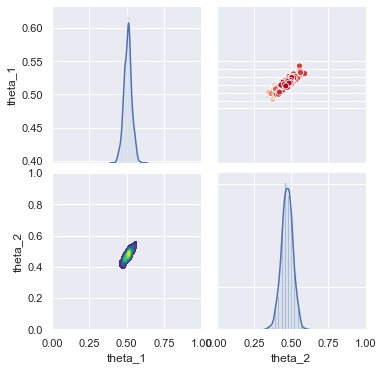

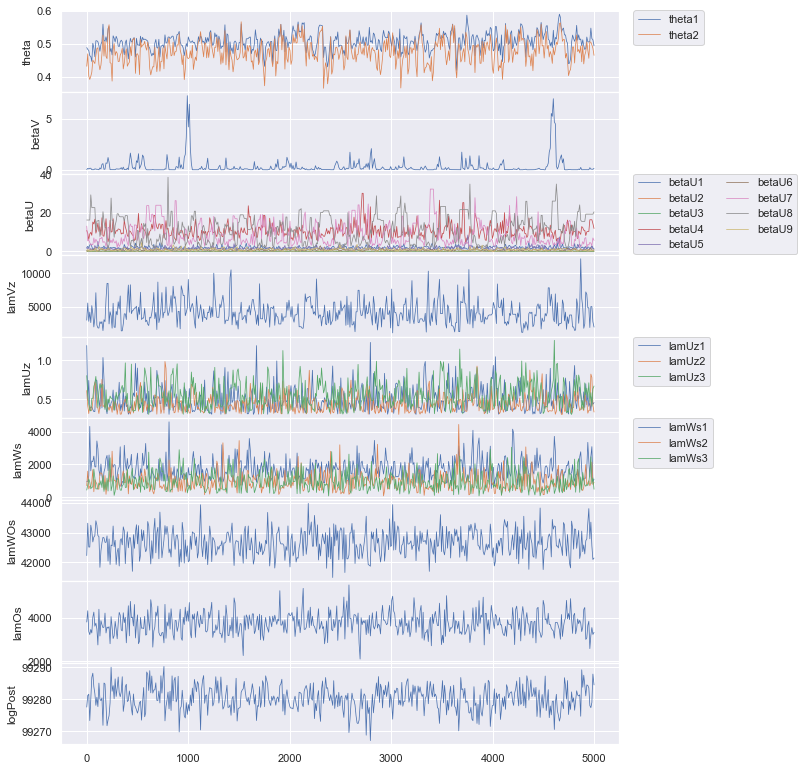

In [31]:
samples_dict = model.get_samples(nburn=1000,effectivesamples=False)
SepiaPlot.theta_pairs(samples_dict)
SepiaPlot.mcmc_trace(samples_dict)

In [32]:
SepiaPlot.param_stats(samples_dict)

,mean,sd,0.05 quantile,0.95 quantile
theta_1,0.5078,0.0268,0.4637,0.5534
theta_2,0.4735,0.0383,0.4098,0.5363
betaV,0.3054,0.7591,0.0028,1.3228
betaU_1,1.9626,0.7247,1.0266,3.3462
betaU_2,0.0641,0.0387,0.0207,0.1423
betaU_3,0.0992,0.0635,0.0327,0.2298
betaU_4,10.9380,3.6159,6.3874,17.4893
betaU_5,1.5925,0.8457,0.7495,2.9037
betaU_6,0.7290,0.3456,0.3167,1.3278
betaU_7,8.8055,5.8821,2.9740,20.7616


# Case 2: Optimization and step size tuning

In [33]:
override=0
cachefile_name='pkls/neddermeyer_optim_nm.pkl'
if os.path.isfile(cachefile_name) and override==0:
    model2=pickle.load(open(cachefile_name, "rb" ))
else:
    model2=SepiaModel(data)
    optimizer = SepiaOptim(model2)
    opt_prm2, history2, p_native2 = optimizer.nelder_mead(maxiter=10000,step_tol=1,obj_tol=1,start='random',\
                                                          log_transform=['betaU','betaV','lamVz','lamWs','lamWOs','lamOs'])
    model2.tune_step_sizes(50, 20, update_vals=False)
    model2.do_mcmc(5000)
    pickle.dump(model2, open( cachefile_name, "w+b" ))

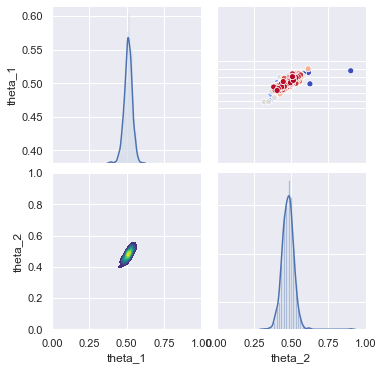

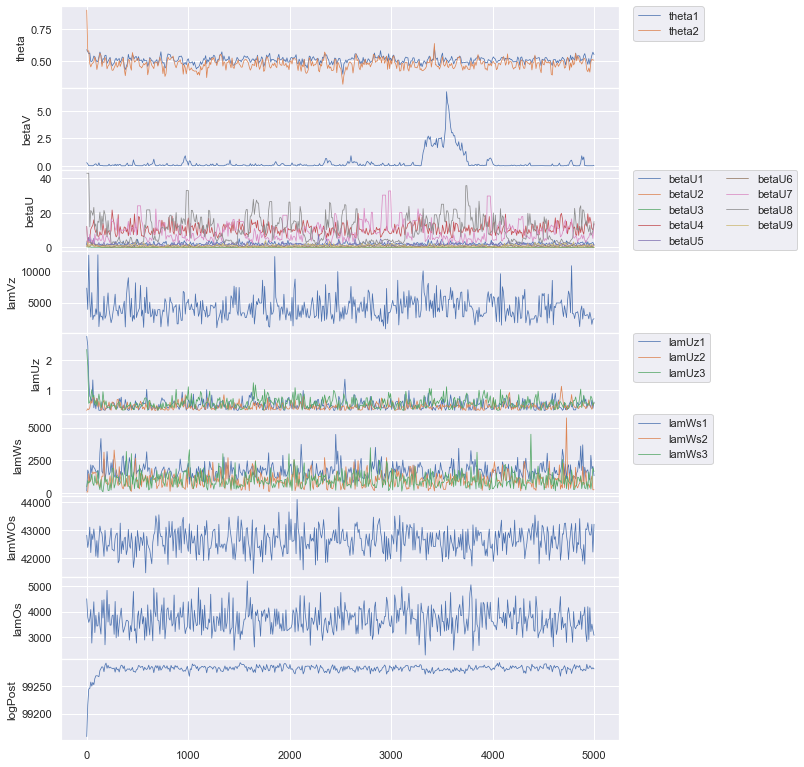

In [34]:
samples_dict2 = model2.get_samples(nburn=1000,effectivesamples=False)
SepiaPlot.theta_pairs(samples_dict2)
SepiaPlot.mcmc_trace(samples_dict2)

# Case 3: pso optim and step

In [35]:
override=0
cachefile_name='pkls/neddermeyer_optim_pso.pkl'
if os.path.isfile(cachefile_name) and override==0:
    model3=pickle.load(open(cachefile_name, "rb" ))
else:
    model3=SepiaModel(data)
    optimizer = SepiaOptim(model3)
    x_opt3, f_opt3, f_hist3, it33, fnc_cals3, p_native3 = optimizer.particle_swarm(maxiter=1000,swarmsize=100,w_max=.9,w_min=.4,c1=.5,c2=.3,\
                                                          log_transform=['betaU','betaV','lamUz','lamVz','lamWs','lamWOs','lamOs'])
    model3.tune_step_sizes(50, 20, update_vals=False)
    model3.do_mcmc(5000)
    pickle.dump(model3, open( cachefile_name, "w+b" ))

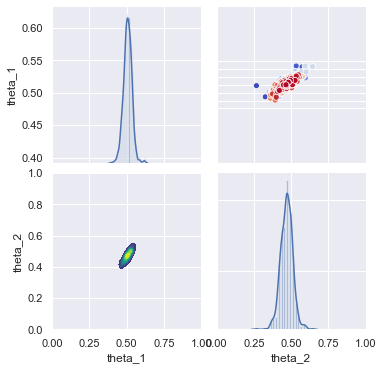

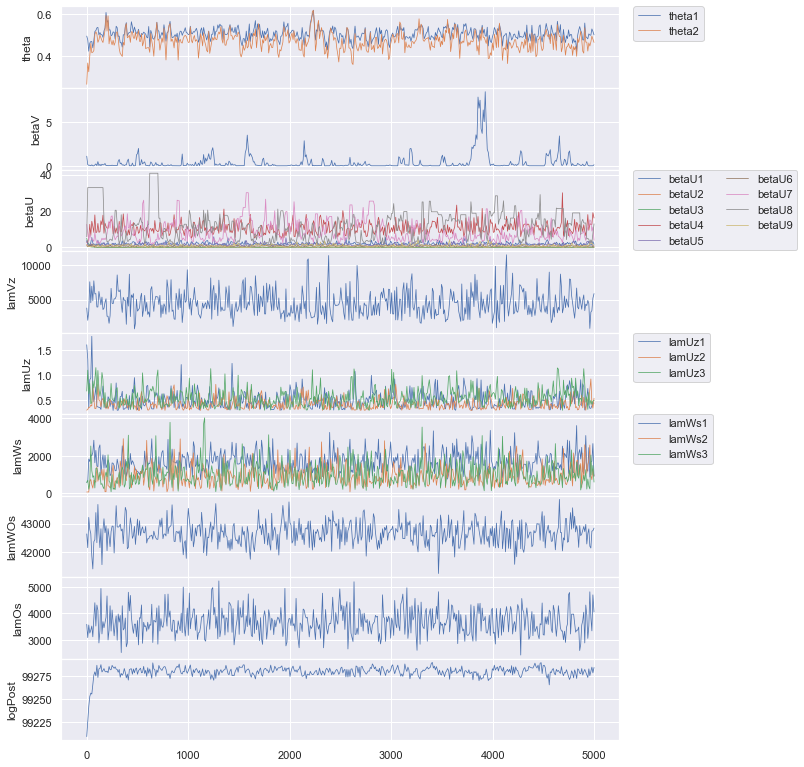

In [36]:
samples_dict3 = model3.get_samples()
SepiaPlot.theta_pairs(samples_dict3)
SepiaPlot.mcmc_trace(samples_dict3)

# Case 4: optimization no step size tuning

In [37]:
override=0
cachefile_name='pkls/neddermeyer_opt_nostep.pkl'
if os.path.isfile(cachefile_name) and override==0:
    model4=pickle.load(open(cachefile_name, "rb" ))
else:
    model4 = SepiaModel(data)
    optimizer = SepiaOptim(model4)
    opt_prm4, history4, p_native4 = optimizer.nelder_mead(maxiter=10000,step_tol=1,obj_tol=1,log_transform=['betaU','betaV','lamVz','lamWs','lamWOs','lamOs'])
    model4.do_mcmc(5000)
    pickle.dump(model4, open( cachefile_name, "w+b" ))

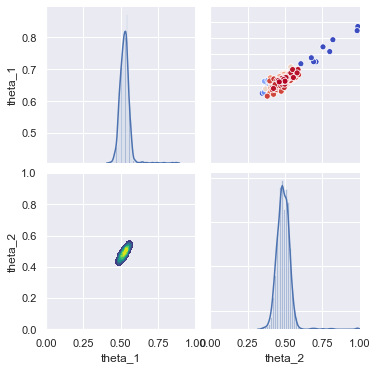

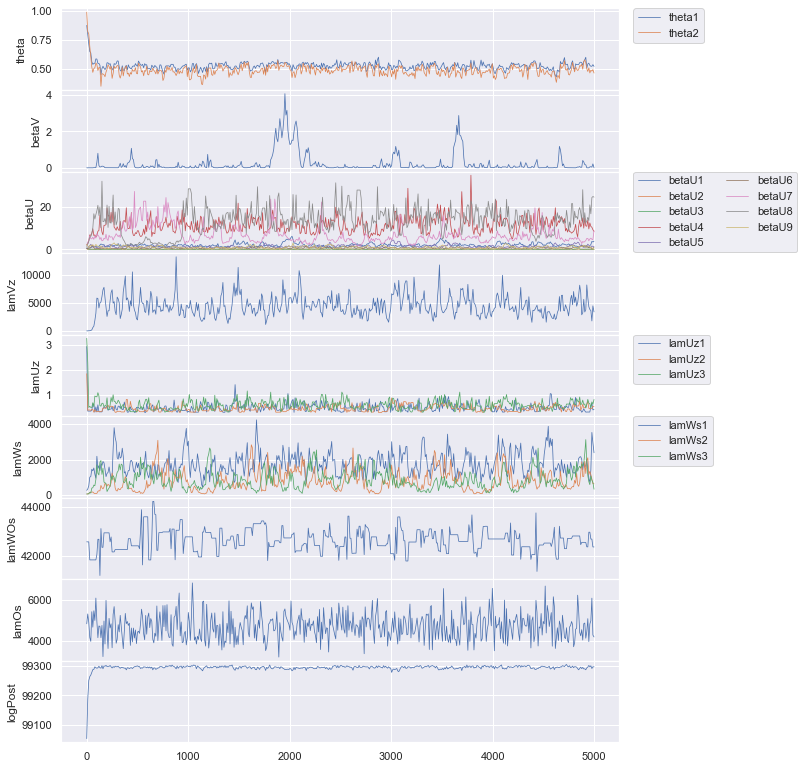

In [38]:
samples_dict4 = model4.get_samples(nburn=1000,effectivesamples=False)
SepiaPlot.theta_pairs(samples_dict4)
SepiaPlot.mcmc_trace(samples_dict4)

# ACF

### Case 1: Step Size Tuning, No Optimization

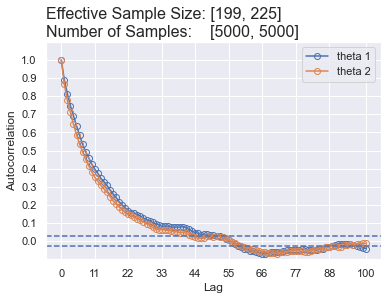

0.045


In [39]:
#_ = SepiaPlot.plot_acf(model,nlags=100,nburn=1000); print(175/4000)
_ = SepiaPlot.plot_acf(model,nlags=100,nburn=0,save=True); print(225/5000)

### Case 2: NM Optimization AND Step Size Tuning

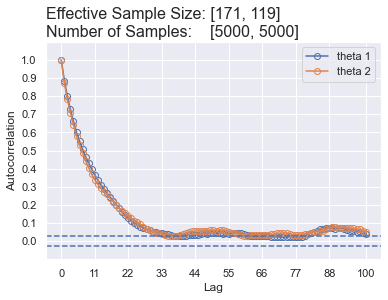

0.08


In [40]:
#_ = SepiaPlot.plot_acf(model2,nlags=100,nburn=1000); print(720/4000)
_ = SepiaPlot.plot_acf(model2,nlags=100,nburn=0,save=True); print(400/5000)

### Case 3: No Optimization, No Step Size Tuning

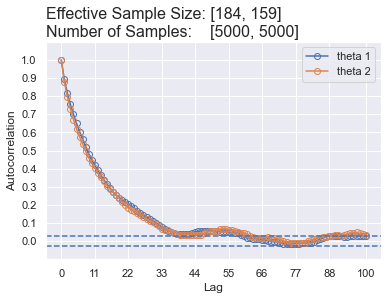

0.0142


In [41]:
#_ = SepiaPlot.plot_acf(model3,nlags=100,nburn=1000); print(82/4000)
_ = SepiaPlot.plot_acf(model3,nlags=100,nburn=0,save=True); print(71/5000)

### Case 4: Optimization, No Step Size Tuning

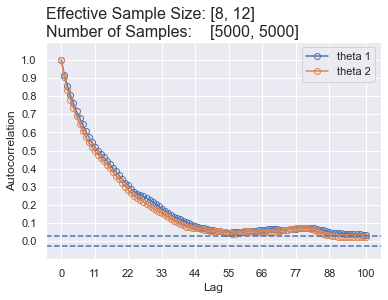

0.0318


In [42]:
#_ = SepiaPlot.plot_acf(model4,nlags=100,nburn=1000); print(153/4000)
_ = SepiaPlot.plot_acf(model4,nlags=100,nburn=0); print(159/5000)

# ###########################################################################
# Optimization Study - vary parameters for PSO and Tolerances for Nelder-Mead

# Nelder-mead with different tolerances

In [43]:
tols = np.linspace(.001,10,design.shape[0])
override=0
cachefile_name='pkls/optimstudy_nelder_mead.pkl'
if os.path.isfile(cachefile_name) and override==0:
    nm_out=pickle.load(open(cachefile_name, "rb" ))
else:
    nm_out = [None]*len(tols)
    for i in range(len(nm_out)):
        print(i)
        model_nm = SepiaModel(data)
        optimizer = SepiaOptim(model_nm)
        nm_out[i] = optimizer.nelder_mead(maxiter=100000,step_tol=tols[i],obj_tol=tols[i],\
                                          log_transform=['betaU','betaV','lamUz','lamVz','lamWs','lamWOs','lamOs'])
    pickle.dump(nm_out, open( 'pkls/optimstudy_nelder_mead.pkl', "w+b" ))

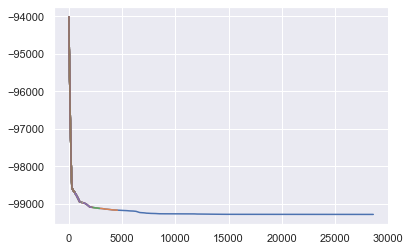

     n_iter  f_evals       max_obj    theta1    theta2
0   28601.0  40226.0  99287.203277  1.000000  0.892621
1    4549.0   6565.0  99173.843282  0.912673  0.999086
2    2869.0   4244.0  99126.345091  0.714340  0.873727
3    2163.0   3221.0  99097.643274  0.797389  0.941552
4    2111.0   3140.0  99096.084437  0.806671  0.952076
5    1277.0   1902.0  98971.479147  0.971051  0.994722
6    1251.0   1862.0  98970.217623  0.965737  0.990810
7    1237.0   1843.0  98969.494391  0.970738  0.999220
8    1220.0   1815.0  98968.568432  0.970426  0.994337
9    1176.0   1746.0  98964.775617  0.970435  0.991482
10   1154.0   1713.0  98962.707577  0.966700  0.991343
11   1118.0   1661.0  98959.423980  0.973369  0.999797
12   1117.0   1660.0  98959.423980  0.973369  0.999797
13   1090.0   1620.0  98956.869347  0.967553  0.992423
14   1088.0   1617.0  98956.869347  0.967553  0.992423
15   1087.0   1616.0  98956.869347  0.967553  0.992423
16   1082.0   1608.0  98956.520773  0.969783  0.992925
17   1080.

In [44]:
df_nm = pd.DataFrame(columns=['n_iter','f_evals', 'max_obj', 'theta1', 'theta2'])
for i,tmp in enumerate(nm_out):
    df_nm.loc[i] = [tmp[0]['nit'], tmp[0]['nfev'], -1*tmp[0]['fun'], tmp[0]['x'][0], tmp[0]['x'][1]]
    plt.plot(tmp[1])
plt.show()
print(df_nm.sort_values('max_obj',ascending=False))

# Nelder-mead with random start location and fixed tolerance

In [45]:
override=0
cachefile_name='pkls/optimstudy_nelder_mead_random.pkl'
if os.path.isfile(cachefile_name) and override==0:
    nm_out_rand=pickle.load(open(cachefile_name, "rb" ))
else:
    nm_out_rand = [None]*len(tols)
    for i in range(len(nm_out)):
        print(i)
        model_nm = SepiaModel(data)
        optimizer = SepiaOptim(model_nm)
        nm_out_rand[i] = optimizer.nelder_mead(maxiter=100000,step_tol=1,obj_tol=1,start='random',\
                                               log_transform=['betaU','betaV','lamUz','lamVz','lamWs','lamWOs','lamOs'])
    pickle.dump(nm_out_rand, open( cachefile_name, "w+b" ))

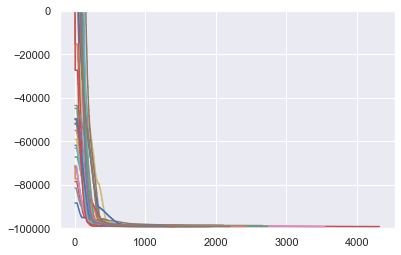

    n_iter  f_evals       max_obj    theta1    theta2
16  3549.0   4965.0  99259.866920  0.344008  0.323059
17  1868.0   2523.0  99225.542545  0.521501  0.412416
28  1299.0   1752.0  99220.041495  0.318919  0.111769
11  1612.0   2210.0  99214.564503  0.187774  0.107663
29  1359.0   1832.0  99211.977997  0.555972  0.529922
5   1930.0   2740.0  99206.056901  0.480910  0.174147
3   4323.0   6088.0  99205.579557  0.165348  0.144256
23  1402.0   1933.0  99203.987727  0.438443  0.392909
15  1916.0   2735.0  99197.307277  0.991420  0.995222
35  2203.0   3121.0  99191.886492  0.695630  0.621201
10  1656.0   2319.0  99190.312518  0.833806  0.999932
4   1305.0   1817.0  99180.323731  0.985708  0.140759
19  1956.0   2734.0  99176.217371  0.121984  0.093560
6   1386.0   1888.0  99174.945981  0.001899  0.522377
31  2422.0   3461.0  99173.409106  0.133310  0.568026
13  1413.0   2070.0  99172.798144  0.067632  0.223633
32  1043.0   1433.0  99172.788044  0.323105  0.777398
24  1314.0   1813.0  99170.0

In [46]:
df_nm_rand = pd.DataFrame(columns=['n_iter','f_evals', 'max_obj', 'theta1', 'theta2'])
for i,tmp in enumerate(nm_out_rand):
    df_nm_rand.loc[i] = [tmp[0]['nit'], tmp[0]['nfev'], -1*tmp[0]['fun'], tmp[0]['x'][0], tmp[0]['x'][1]]
    plt.plot(tmp[1])
plt.ylim(-100000,0)
plt.show()
print(df_nm_rand.sort_values('max_obj',ascending=False))

# Pyswarm particle swarm optimization

### default parameters, linearly decreasing intertia .9->.4, c1=.5, c2=.3

In [47]:
model_pso = SepiaModel(data)
optimizer = SepiaOptim(model_pso)

In [48]:
x_opt, f_opt, f_hist, it, fnc_calls, p_native = optimizer.particle_swarm(maxiter=500,swarmsize=100,\
                                                            log_transform=['betaU','betaV','lamVz','lamUz','lamWs','lamWOs','lamOs'],\
                                                              w_max=.9,w_min=.4,c1=.5,c2=.3)

  0%|          | 0/500 [00:00<?, ?it/s]

optimization bounds: ([0.0, 0.0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1.2039728043259361, -1.2039728043259361, -1.2039728043259361, 4.0943445622221, 4.0943445622221, 4.0943445622221, 4.0943445622221, -1], [1.0, 1.0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 11.512925464970229, 11.512925464970229, 11.512925464970229, 11.512925464970229, 11.512925464970229, 11.512925464970229, 11.512925464970229, 11.512925464970229, 11.512925464970229])


 59%|█████▊    | 293/500 [00:41<00:29,  7.03it/s]

Stopping search: Swarm best position change less than 1e-08
max obj fnc: -99279.57222845804
  param  opt value native
  theta          0.508443
  theta          0.471130
  betaV         17.461683
  betaU          1.286736
  betaU          0.029707
  betaU          0.041728
  betaU         20.085537
  betaU          1.504171
  betaU          1.308843
  betaU          8.011191
  betaU          3.106162
  betaU          1.180834
  lamVz       5188.320573
  lamUz          0.300231
  lamUz          0.705085
  lamUz          0.309482
  lamWs       1230.839246
  lamWs        502.862161
  lamWs        632.098819
 lamWOs      42671.142404
  lamOs       3788.027066


-99279.57222845804


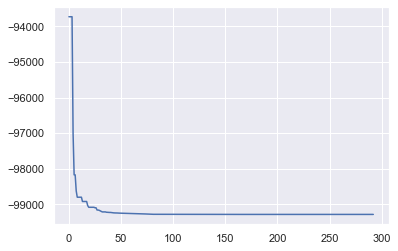

In [49]:
print(f_opt)
plt.plot(f_hist)

In [50]:
override=0
cachefile_name='pkls/neddermeyer_pso.pkl'
if os.path.isfile(cachefile_name) and override==0:
    model_pso=pickle.load(open(cachefile_name, "rb" ))
else:
    model_pso.tune_step_sizes(50, 20, update_vals=False)
    model_pso.do_mcmc(1000)
    pickle.dump(model_pso, open( cachefile_name, "w+b" ))

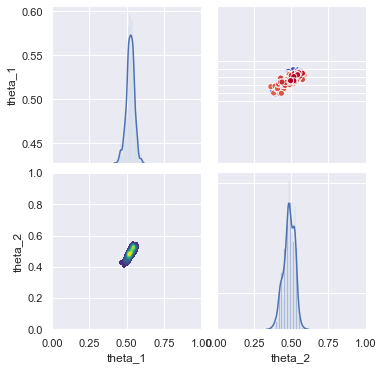

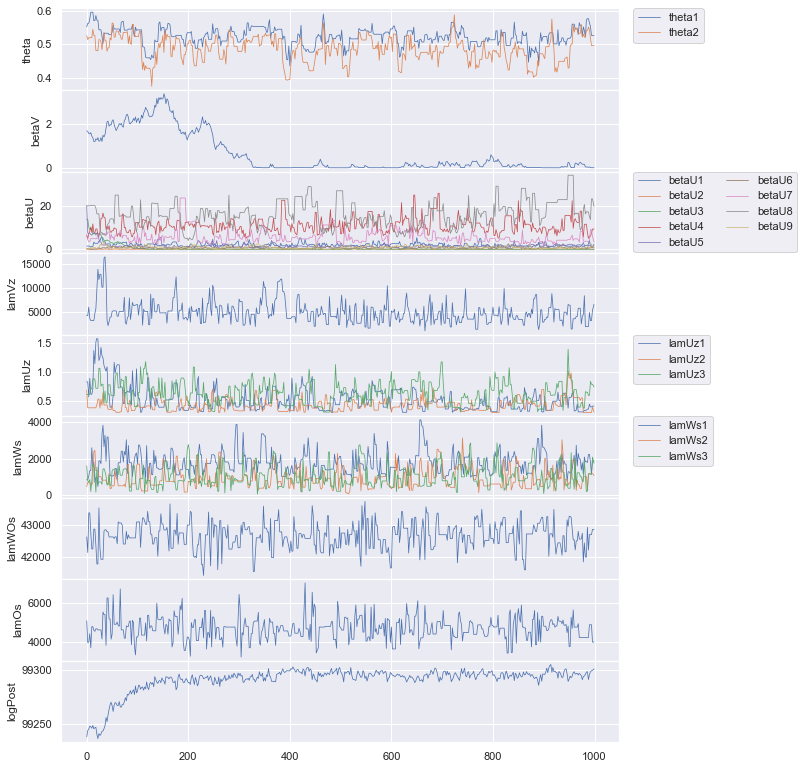

In [51]:
samples_dict_pso = model_pso.get_samples()
SepiaPlot.theta_pairs(samples_dict_pso)
SepiaPlot.mcmc_trace(samples_dict_pso)

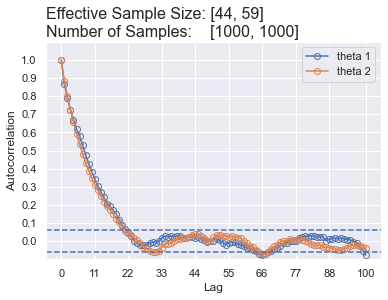

In [52]:
_ = SepiaPlot.plot_acf(model_pso,nlags=100,nburn=0)

## Latin Hypercube design with linearly decreasing w from .9 to .4

In [53]:
# try a bunch of parameters, we have a LHCD in 'design'
override=0
cachefile_name='pkls/optimstudy_lin_dec.pkl'
if os.path.isfile(cachefile_name) and override==0:
    out=pickle.load(open(cachefile_name, "rb" ))
else:
    model_pso = SepiaModel(data)
    optimizer = SepiaOptim(model_pso)
    out = [None]*design.shape[0]
    for i in range(len(out)):
        out[i] = [optimizer.particle_swarm(swarmsize=100,maxiter=500, w_max=.9, w_min=.4, c1=design[i,1], c2=design[i,2],\
                                          log_transform=['betaU','betaV','lamVz','lamUz','lamWs','lamWOs','lamOs']),design[i,:]]
    pickle.dump(out, open( 'pkls/optimstudy_lin_dec.pkl', "w+b" ))

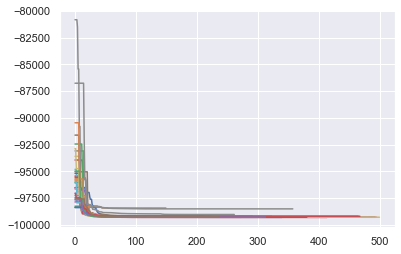

    n_iter       max_obj    theta1        theta2      c1      c2
3    415.0  99309.241486  0.520132  4.781205e-01  0.6000  0.8000
4    341.0  99304.704678  0.557881  5.379922e-01  0.6286  0.4000
23   274.0  99296.534251  0.519232  4.808954e-01  0.1714  0.8571
25   494.0  99294.990812  0.010414  9.000823e-03  0.4000  0.8286
30   382.0  99290.018351  0.068756  5.482056e-02  0.7429  0.5429
28   501.0  99288.943483  0.787636  7.086238e-01  0.8571  0.9143
6    335.0  99287.560264  0.994653  8.795856e-01  1.0000  0.6286
1    306.0  99285.240912  0.039106  3.996057e-02  0.1143  0.7143
18   280.0  99281.782087  0.490388  4.346475e-01  0.9143  0.3429
10   322.0  99281.698938  0.586764  5.262932e-01  0.2000  1.0000
16   496.0  99278.404668  0.741841  6.591327e-01  0.5714  0.7429
34   314.0  99277.702064  0.424989  2.503143e-01  0.9714  0.3143
21   295.0  99277.217842  0.999564  8.684282e-01  0.0857  0.9714
32   308.0  99276.690696  0.791328  7.131435e-01  0.3714  0.4286
20   264.0  99273.164345 

In [54]:
df_lw = pd.DataFrame(columns=['n_iter', 'max_obj', 'theta1', 'theta2', 'c1', 'c2'])
for i,tmp in enumerate(out):
    df_lw.loc[i] = [tmp[0][3], -1*tmp[0][1], tmp[0][0][0], tmp[0][0][1], tmp[1][1], tmp[1][2]]
    plt.plot(tmp[0][2])
plt.show()
print(df_lw.sort_values('max_obj',ascending=False))

## Latin Hypercube Design with constant w

In [55]:
override=0
cachefile_name='pkls/optimstudy.pkl'
if os.path.isfile(cachefile_name) and override==0:
    out2=pickle.load(open(cachefile_name, "rb" ))
else:
    out2 = [None]*design.shape[0]
    for i in range(len(out2)):
        out2[i] = [optimizer.particle_swarm(swarmsize=100,maxiter=500,w_max=design[i,0], w_min=design[i,0],\
                                                              c1=design[i,1], c2=design[i,2],\
                                           log_transform=['betaU','betaV','lamVz','lamUz','lamWs','lamWOs','lamOs']),design[i,:]]
    pickle.dump(out2, open( 'pkls/optimstudy.pkl', "w+b" ))

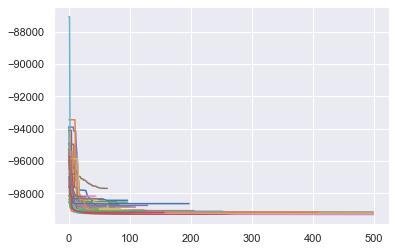

    run_index  n_iter       max_obj    theta1    theta2       w      c1  \
14       14.0   501.0  99309.242488  0.518133  0.478957  0.9143  0.8857   
26       26.0   501.0  99300.600266  0.098491  0.084226  0.9429  0.6857   
23       23.0   307.0  99289.181173  0.525605  0.488310  0.7143  0.1714   
9         9.0   455.0  99282.485960  0.554865  0.527886  0.6857  0.3143   
4         4.0   316.0  99280.651501  0.551272  0.534820  0.8000  0.6286   
10       10.0   501.0  99277.200041  0.999992  0.879211  0.8286  0.2000   
6         6.0   501.0  99255.088867  0.594852  0.626936  0.6571  1.0000   
19       19.0   501.0  99235.968047  0.597087  0.546876  0.6286  0.7143   
21       21.0   501.0  99232.950308  0.780298  0.554737  0.8857  0.0857   
28       28.0   501.0  99225.865560  0.426496  0.327353  1.0000  0.8571   
11       11.0   501.0  99204.467259  0.529384  0.458711  0.9714  0.3429   
33       33.0   158.0  99188.787563  0.361978  0.092268  0.4286  0.7714   
31       31.0   410.0  99

In [56]:
df_cw = pd.DataFrame(columns=['run_index', 'n_iter', 'max_obj', 'theta1', 'theta2', 'w', 'c1', 'c2'])
for i,tmp in enumerate(out2):
    df_cw.loc[i] = [i, tmp[0][3], -1*tmp[0][1], tmp[0][0][0], tmp[0][0][1], tmp[1][0], tmp[1][1], tmp[1][2]]
    plt.plot(tmp[0][2][0:500])
plt.show()
print(df_cw.sort_values('max_obj',ascending=False))

## First compare just particle swarm

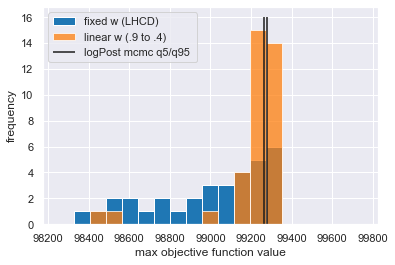

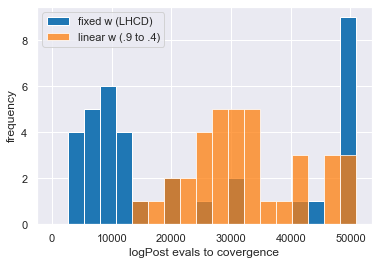

In [86]:
obj_bins = np.linspace(98250,99750,20)
fev_bins= np.linspace(0,51000,20)
lpq5 = 99266.2877; lpq95 = 99280.4342

plt.hist(df_cw['max_obj'],bins=obj_bins,alpha=1,color='#1f77b4',label='fixed w (LHCD)')
plt.xlabel('max objective function value'); plt.ylabel('frequency')
plt.hist(df_lw['max_obj'],bins=obj_bins,alpha=.75,color='#ff7f0e',label='linear w (.9 to .4)')
plt.vlines((lpq5,lpq95),ymin=0,ymax=16,label='logPost mcmc q5/q95 ') # quantiles for no optimization before mcmc 
plt.legend()
plt.savefig('plots/maxobjswarm.png',dpi=300)
plt.show()
plt.hist(df_cw['n_iter']*100,bins=fev_bins,alpha=1,color='#1f77b4',label='fixed w (LHCD)')
plt.hist(df_lw['n_iter']*100,bins=fev_bins,alpha=.75,color='#ff7f0e',label='linear w (.9 to .4)')

plt.xlabel('logPost evals to covergence'); plt.ylabel('frequency')
plt.legend()
plt.savefig('plots/iterswarm.png',dpi=300)
plt.show()

## Compare nelder-mead with particle swarm

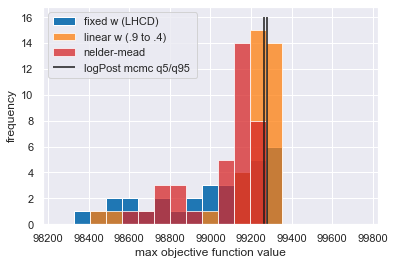

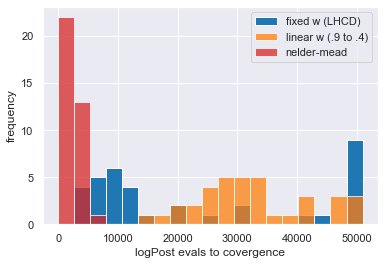

In [96]:
fig,ax = plt.subplots()
ax.hist(df_cw['max_obj'],bins=obj_bins,alpha=1,color='#1f77b4',label='fixed w (LHCD)')
ax.set_xlabel('max objective function value'); ax.set_ylabel('frequency')
ax.hist(df_lw['max_obj'],bins=obj_bins,alpha=.75,color='#ff7f0e',label='linear w (.9 to .4)')
#plt.hist(df_nm['max_obj'],bins=obj_bins,alpha=1,color='#2ca02c',label='nelder-mead')
ax.hist(df_nm_rand['max_obj'],bins=obj_bins,alpha=.75,color='#d62728',label='nelder-mead')
ax.vlines((lpq5,lpq95),ymin=0,ymax=16,label='logPost mcmc q5/q95 ') # quantiles for no optimization before mcmc 
plt.legend()
plt.savefig('plots/maxobjswarm_and_nm.png',dpi=300)
plt.show()

fig,ax = plt.subplots()
ax.hist(df_cw['n_iter']*100,bins=fev_bins,alpha=1,color='#1f77b4',label='fixed w (LHCD)')
ax.hist(df_lw['n_iter']*100,bins=fev_bins,alpha=.75,color='#ff7f0e',label='linear w (.9 to .4)')
#plt.hist(df_nm['f_evals'],bins=fev_bins,alpha=1,color='#2ca02c',label='nelder-mead')
ax.hist(df_nm_rand['f_evals'],bins=fev_bins,alpha=.75,color='#d62728',label='nelder-mead')

ax.set_xlabel('logPost evals to covergence'); ax.set_ylabel('frequency')
plt.legend()
plt.savefig('plots/iterswarm_and_nm.png',dpi=300)
plt.show()

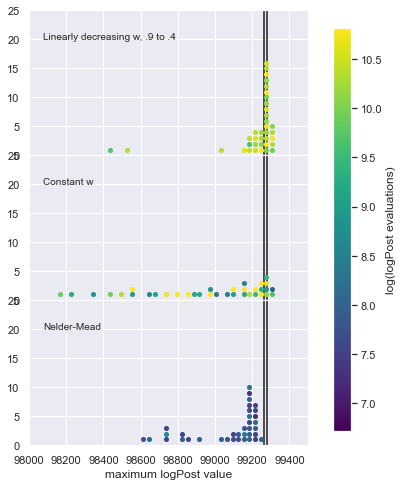

In [72]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
markersize=4
cmap = cm.viridis
vmin = min(min(df_lw['n_iter']*100),min(df_cw['n_iter']*100),min(df_nm['f_evals']),min(df_nm_rand['f_evals']))
vmax = max(max(df_lw['n_iter']*100),max(df_cw['n_iter']*100),max(df_nm['f_evals']),max(df_nm_rand['f_evals']))
norm = Normalize(vmin=np.log(vmin), vmax=np.log(vmax))

fig,axs = plt.subplots(nrows=3,sharex=True,figsize=(5,8))
xmin = 98000; xmax = 99500
ymin = 0; ymax = 25
nbins = 50
lpq5 = 99266.2877; lpq95 = 99280.4342

counts,bin_edges = np.histogram(df_lw['max_obj'],bins=nbins,range=(xmin,xmax))
# Centers via the mean to be robust to non-evenly spaced bins
bin_centers = np.mean(np.vstack((bin_edges[1:],bin_edges[:-1])),axis=0)
j = 0
for count,bin_center in zip(counts,bin_centers):
    y = np.arange(count)+1 # 1...count
    x = 0*y + bin_center
    for i in range(len(x)):
        axs[0].plot(x[i],y[i],'o',color=cmap(norm(np.log(df_lw['n_iter'][j]*100))),markersize=markersize)
        j+=1
axs[0].set_xlim((xmin,xmax))
axs[0].set_ylim((ymin,ymax))
axs[0].vlines((lpq5,lpq95),ymin=ymin,ymax=ymax)
axs[0].text(xmin+75,ymax*.8,'Linearly decreasing w, .9 to .4')

# constant w
counts,bin_edges = np.histogram(df_cw['max_obj'],bins=nbins,range=(xmin,xmax))
# Centers via the mean to be robust to non-evenly spaced bins
bin_centers = np.mean(np.vstack((bin_edges[1:],bin_edges[:-1])),axis=0)
j = 0
for count,bin_center in zip(counts,bin_centers):
    y = np.arange(count)+1 # 1...count
    x = 0*y + bin_center
    for i in range(len(x)):
        axs[1].plot(x[i],y[i],'o',color=cmap(norm(np.log(df_cw['n_iter'][j]*100))),markersize=markersize)
        j+=1  
axs[1].set_xlim((xmin,xmax))
axs[1].set_ylim((ymin,ymax))
axs[1].vlines((lpq5,lpq95),ymin=ymin,ymax=ymax)
axs[1].text(xmin+75,ymax*.8,'Constant w')
axs[1].set_xlabel('maximum logPost value')

# Nelder-mead
#counts,bin_edges = np.histogram(df_nm['max_obj'],bins=nbins,range=(xmin,xmax))
# Centers via the mean to be robust to non-evenly spaced bins
#bin_centers = np.mean(np.vstack((bin_edges[1:],bin_edges[:-1])),axis=0)
#j = 0
#for count,bin_center in zip(counts,bin_centers):
#    y = np.arange(count)+1 # 1...count
#    x = 0*y + bin_center
#    for i in range(len(x)):
#        axs[2].plot(x[i],y[i],'o',color=cmap(norm(np.log(df_nm['f_evals'][j]))),markersize=markersize)
#        j+=1  
#axs[2].set_xlim((xmin,xmax))
#axs[2].set_ylim((ymin,ymax))
#axs[2].vlines((lpq5,lpq95),ymin=ymin,ymax=ymax)
#axs[2].text(xmin+75,ymax*.8,'Nelder-Mead')
#axs[2].set_xlabel('maximum logPost value')

# random start Nelder-mead
counts,bin_edges = np.histogram(df_nm_rand['max_obj'],bins=nbins,range=(xmin,xmax))
# Centers via the mean to be robust to non-evenly spaced bins
bin_centers = np.mean(np.vstack((bin_edges[1:],bin_edges[:-1])),axis=0)
j = 0
for count,bin_center in zip(counts,bin_centers):
    y = np.arange(count)+1 # 1...count
    x = 0*y + bin_center
    for i in range(len(x)):
        axs[2].plot(x[i],y[i],'o',color=cmap(norm(np.log(df_nm_rand['f_evals'][j]))),markersize=markersize)
        j+=1  
axs[2].set_xlim((xmin,xmax))
axs[2].set_ylim((ymin,ymax))
axs[2].vlines((lpq5,lpq95),ymin=ymin,ymax=ymax)
axs[2].text(xmin+75,ymax*.8,'Nelder-Mead')
axs[2].set_xlabel('maximum logPost value')

# colorbar
cax = fig.add_axes([.97, 0.15, 0.05, 0.7])
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
     cax=cax, orientation='vertical', label='log(logPost evaluations)')

plt.subplots_adjust(hspace=0)
plt.savefig('plots/compareIters.png',dpi=300,bbox_inches = "tight")
plt.show()

# MCMC transient length

## Nelder-mead

### fixed start, change tolerance

In [61]:
override=0
#cachefile_name='pkls/nm_mcmc_transient_upd.pkl'
cachefile_name='pkls/nm_mcmc_transient.pkl'
if os.path.isfile(cachefile_name) and override==0:
    nm_models=pickle.load(open(cachefile_name, "rb" ))
else:
    nm_models = []
    for opt_results in nm_out:
        nm_models.append(SepiaModel(data))
        opt_params = opt_results[2]
        # set model param vals to opt values
        i=0
        for prm in nm_models[-1].params.mcmcList:
            # Loop over indices within parameter
            for ind in range(int(np.prod(prm.val_shape))):
                arr_ind = np.unravel_index(ind, prm.val_shape, order='F')
                prm.val[arr_ind] = opt_params[i]
                i+=1
        # run mcmc
        nm_models[-1].tune_step_sizes(50, 20, update_vals=False)
        nm_models[-1].do_mcmc(1000)
    pickle.dump(nm_models, open( 'pkls/nm_mcmc_transient.pkl', "w+b" ))

In [62]:
# get all 5% quantiles for logpost
nm_trans_len = []
for model in nm_models:
    samples = model.get_samples()
    q5 = np.quantile(samples['logPost'][500:],.05)
    nm_trans_len.append(np.argmax(samples['logPost']>q5))
df_nm['trans_len'] = nm_trans_len

### random start, fixed tolerance

In [63]:
override=0
cachefile_name='pkls/nm_rand_mcmc_transient.pkl'
if os.path.isfile(cachefile_name) and override==0:
    nm_rand_models=pickle.load(open(cachefile_name, "rb" ))
else:
    nm_rand_models = []
    for opt_results in nm_out_rand:
        nm_rand_models.append(SepiaModel(data))
        opt_params = opt_results[2]
        # set model param vals to opt values
        i=0
        for prm in nm_rand_models[-1].params.mcmcList:
            # Loop over indices within parameter
            for ind in range(int(np.prod(prm.val_shape))):
                arr_ind = np.unravel_index(ind, prm.val_shape, order='F')
                prm.val[arr_ind] = opt_params[i]
                i+=1
        # run mcmc
        nm_rand_models[-1].tune_step_sizes(50, 20, update_vals=False)
        nm_rand_models[-1].do_mcmc(1000)
    pickle.dump(nm_rand_models, open( 'pkls/nm_rand_mcmc_transient.pkl', "w+b" ))

In [64]:
# get all 5% quantiles for logpost
trans_len = []
for model in nm_rand_models:
    samples = model.get_samples()
    q5 = np.quantile(samples['logPost'][500:],.05)
    trans_len.append(np.argmax(samples['logPost']>q5))
df_nm_rand['trans_len'] = trans_len

## linear decreasing w

In [65]:
override=0
cachefile_name='pkls/linWmcmcTransient.pkl'
if os.path.isfile(cachefile_name) and override==0:
    models=pickle.load(open(cachefile_name, "rb" ))
else:
    models = []
    for opt_result in out:
        models.append(SepiaModel(data))
        opt_params = opt_result[0][5]
        # set model param vals to opt values
        i = 0
        for prm in models[-1].params.mcmcList:
            # Loop over indices within parameter
            for ind in range(int(np.prod(prm.val_shape))):
                arr_ind = np.unravel_index(ind, prm.val_shape, order='F')
                prm.val[arr_ind] = opt_params[i]
                i+=1
        # run mcmc
        models[-1].tune_step_sizes(50, 20, update_vals=False)
        models[-1].do_mcmc(1000)  
    pickle.dump(models, open( 'pkls/linWmcmcTransient.pkl', "w+b" ))

In [66]:
# get all 5% quantiles for logpost
trans_len = []
for model in models:
    samples = model.get_samples()
    q5 = np.quantile(samples['logPost'][500:],.05)
    trans_len.append(np.argmax(samples['logPost']>q5))
df_lw['trans_len'] = trans_len

## constant w

In [67]:
override=0
cachefile_name='pkls/constWmcmcTransient.pkl'
if os.path.isfile(cachefile_name) and override==0:
    models2=pickle.load(open(cachefile_name, "rb" ))
else:
    models2 = []
    for opt_result in out2:
        models2.append(SepiaModel(data))
        opt_params = opt_result[0][5]
        # set model param vals to opt values
        i = 0
        for prm in models2[-1].params.mcmcList:
            # Loop over indices within parameter
            for ind in range(int(np.prod(prm.val_shape))):
                arr_ind = np.unravel_index(ind, prm.val_shape, order='F')
                prm.val[arr_ind] = opt_params[i]
                i+=1
        # run mcmc
        models2[-1].tune_step_sizes(50, 20, update_vals=False)
        models2[-1].do_mcmc(1000) 
    pickle.dump(models2, open( 'pkls/constWmcmcTransient.pkl', "w+b" ))

In [68]:
# get all 5% quantiles for logpost
trans_len2 = []
for model in models2:
    samples = model.get_samples()
    q5 = np.quantile(samples['logPost'][500:],.05)
    trans_len2.append(np.argmax(samples['logPost']>q5))
df_cw['trans_len'] = trans_len2

### compare methods mcmc transient length vs convergence time

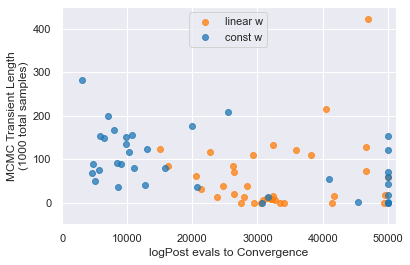

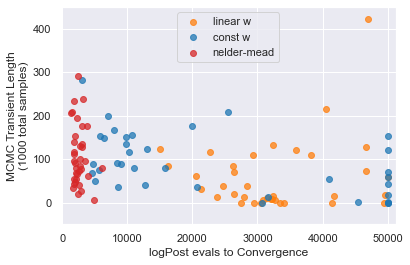

In [97]:
plt.scatter(df_lw['n_iter']*100,df_lw['trans_len'],label='linear w',color='#ff7f0e',alpha=.75)
plt.scatter(df_cw['n_iter']*100,df_cw['trans_len'],label='const w',color='#1f77b4',alpha=.75)
#plt.title('logPost evals vs Transient Length')
plt.xlabel('logPost evals to Convergence')
plt.ylabel('MCMC Transient Length\n(1000 total samples)')
plt.legend(loc='upper center')
plt.xlim(-200,51200)
plt.ylim(-50,450)
plt.savefig('plots/itervstransient.png',dpi=300,bbox_inches = "tight")
plt.show()

plt.scatter(df_lw['n_iter']*100,df_lw['trans_len'],label='linear w',color='#ff7f0e',alpha=.75)
plt.scatter(df_cw['n_iter']*100,df_cw['trans_len'],label='const w',color='#1f77b4',alpha=.75)
#plt.scatter(df_nm['f_evals'],df_nm['trans_len'],label='nelder-mead',color='#2ca02c',alpha=.75)
plt.scatter(df_nm_rand['f_evals'],df_nm_rand['trans_len'],label='nelder-mead',color='#d62728',alpha=.75)
#plt.scatter(0,0,label='control',color='k',alpha=.75)
#plt.title('logPost evals vs Transient Length')
plt.xlabel('logPost evals to Convergence')
plt.ylabel('MCMC Transient Length\n(1000 total samples)')
plt.legend(loc='upper center')
plt.xlim(-200,51200)
plt.ylim(-50,450)
plt.savefig('plots/itervstransient_and_nm.png',dpi=300,bbox_inches = "tight")
plt.show()

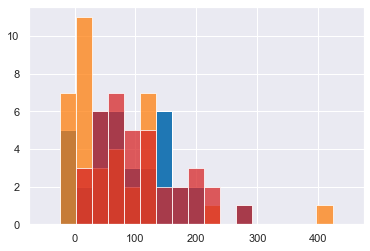

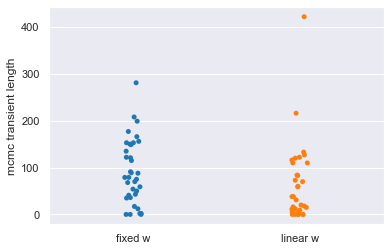

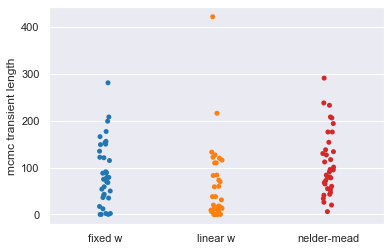

In [133]:
fig,ax = plt.subplots()
trans_bins = np.linspace(-50,450,20)
ax.hist(df_cw['trans_len'],bins=trans_bins,alpha=1,color='#1f77b4',label='fixed w (LHCD)')
ax.hist(df_lw['trans_len'],bins=trans_bins,alpha=.75,color='#ff7f0e',label='linear w (.9 to .4)')
ax.hist(df_nm_rand['trans_len'],bins=trans_bins,alpha=.75,color='#d62728',label='nelder-mead')
plt.show()

names = np.array(['fixed w','linear w', 'nelder-mead'])
names = np.repeat(names,len(df_cw['trans_len']))
trans = np.concatenate((df_cw['trans_len'],df_lw['trans_len'],df_nm_rand['trans_len']))
df_trans = pd.DataFrame(columns=['optimizer','mcmc transient length'])
df_trans['optimizer'] = names
df_trans['mcmc transient length'] = trans
import seaborn as sns
ax = sns.stripplot(x="optimizer", y="mcmc transient length", data=df_trans.loc[df_trans['optimizer'] != 'nelder-mead'], jitter=.05,\
                  palette=['#1f77b4','#ff7f0e'])
ax.set_xlabel('')
plt.savefig('plots/transient_stripchat.png',dpi=300,bbox_inches='tight')
plt.show()
ax = sns.stripplot(x="optimizer", y="mcmc transient length", data=df_trans, jitter=0.05,\
                  palette=['#1f77b4','#ff7f0e','#d62728'])
ax.set_xlabel('')
plt.savefig('plots/transient_stripchat_and_nm.png',dpi=300,bbox_inches='tight')
plt.show()

In [99]:
nm_samples_theta = np.zeros((design.shape[0]*1000,2))
i=0
for model in nm_models:
    nm_samples_theta[i:i+1000,:] = model.get_samples()['theta']
    i+=1000
nm_rand_samples_theta = np.zeros((design.shape[0]*1000,2))
i=0
for model in nm_rand_models:
    nm_rand_samples_theta[i:i+1000,:] = model.get_samples()['theta']
    i+=1000
cw_samples_theta = np.zeros((design.shape[0]*1000,2))
i=0
for model in models2:
    cw_samples_theta[i:i+1000,:] = model.get_samples()['theta']
    i+=1000
lw_samples_theta = np.zeros((design.shape[0]*1000,2))
i=0
for model in models:
    lw_samples_theta[i:i+1000,:] = model.get_samples()['theta']
    i+=1000

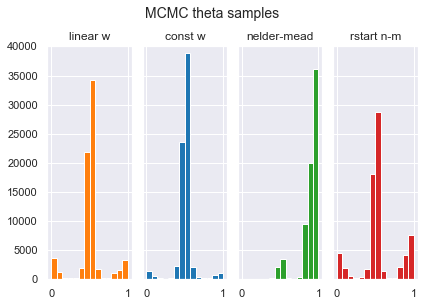

In [100]:
ylims = (0,40000)
bins = np.linspace(0,1,15,endpoint=True)
fig,axs = plt.subplots(1,4,sharey=True,tight_layout=True)
fig.suptitle("MCMC theta samples", fontsize=14,y=1.05)
axs[0].hist(lw_samples_theta.flatten(),bins=bins,color='#ff7f0e')
axs[0].set_title('linear w')
axs[0].set_ylim(ylims)

axs[1].hist(cw_samples_theta.flatten(),bins=bins,color='#1f77b4')
axs[1].set_title('const w')

axs[2].hist(nm_samples_theta.flatten(),bins=bins,color='#2ca02c')
axs[2].set_title('nelder-mead')

axs[3].hist(nm_rand_samples_theta.flatten(),bins=bins,color='#d62728')
axs[3].set_title('rstart n-m')
plt.show()

## Compare posterior means of theta for the three methods

In [101]:
# How many times does nelder-mead miss the mark with theta?
# how many chains does the second half mean not lie in .4-.6?
counts = np.zeros(4)
means = np.zeros((36,2))

i = 0
for model in models:
    means[i,:] = np.mean(model.get_samples()['theta'][500:,:],axis=0)
    if means[i,0] < .4 or means[i,0] > .6: counts[0]+=1
    if means[i,1] < .4 or means[i,1] > .6: counts[0]+=1
    i+=1

means2 = np.zeros((36,2))
i = 0
for model in models2:
    means2[i,:] = np.mean(model.get_samples()['theta'][500:,:],axis=0)
    if means2[i,0] < .4 or means2[i,0] > .6: counts[1]+=1
    if means2[i,1] < .4 or means2[i,1] > .6: counts[1]+=1
    i+=1

nm_means = np.zeros((36,2))
i=0
for model in nm_models:
    nm_means[i,:] = np.mean(model.get_samples()['theta'][500:,:],axis=0)
    if nm_means[i,0] < .4 or nm_means[i,0] > .6: counts[2]+=1
    if nm_means[i,1] < .4 or nm_means[i,1] > .6: counts[2]+=1
    i+=1
    
nm_rand_means = np.zeros((36,2))
i=0
for model in nm_rand_models:
    nm_rand_means[i,:] = np.mean(model.get_samples()['theta'][500:,:],axis=0)
    if nm_rand_means[i,0] < .4 or nm_rand_means[i,0] > .6: counts[3]+=1
    if nm_rand_means[i,1] < .4 or nm_rand_means[i,1] > .6: counts[3]+=1
    i+=1

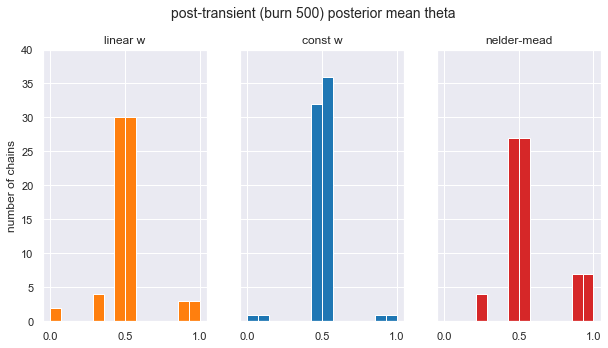

In [103]:
ylims = (0,40)
bins = np.linspace(0,1,15,endpoint=True)
fig,axs = plt.subplots(1,3,sharey=True,tight_layout=False,figsize=[10,5])
fig.suptitle("post-transient (burn 500) posterior mean theta", fontsize=14,y=1)
xticks = (0,.5,1)

axs[0].hist(means.flatten(),bins=bins,color='#ff7f0e')
axs[0].set_title('linear w')
axs[0].set_ylim(ylims)
axs[0].set_xticks(xticks)
axs[0].set_ylabel('number of chains')

axs[1].hist(means2.flatten(),bins=bins,color='#1f77b4')
axs[1].set_title('const w')
axs[1].set_xticks(xticks)

#axs[2].hist(nm_means.flatten(),bins=bins,color='#2ca02c')
#axs[2].set_title('nelder-mead')
#axs[2].set_xticks(xticks)

axs[2].hist(nm_rand_means.flatten(),bins=bins,color='#d62728')
axs[2].set_title('nelder-mead')
axs[2].set_xticks(xticks)

plt.subplots_adjust(wspace=.2)
plt.savefig('plots/theta_means.png',dpi=300,bbox_inches='tight')
plt.show()